In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

from hex import HexGame
from mcts import MCTSPlayer, NeuralMCTSPlayer
from neuralnet import createModel, loadModel
from player import NeuralNetPlayer, RandomPlayer
from tournament import Tournament
import pickle

tf.config.run_functions_eagerly(True)

boardSize = 4

### Sequential games comparison

In [2]:
rounds = 1
model = createModel(size=boardSize)
# model = loadModel('model.h5')
nnMctsPlayer = NeuralMCTSPlayer(model=model, maxIters=1, maxTime=5)
randomPlayer = RandomPlayer()
tournament = Tournament(HexGame, nnMctsPlayer, randomPlayer, boardSize=boardSize)
tournament.run(rounds)
wins, losses, draws = tournament.getResults()
print(f"NN MCTS Player: {wins} wins, {losses} losses, {draws} draws")

replay = nnMctsPlayer.mcts.replayBuffer
# TODO: flip both axis and double the replay buffer
print(f'Length of replay buffer: {len(replay)}')

c:\Users\Jacob\Anaconda3\envs\pytorch\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


NN MCTS Player: 1 wins, 0 losses, 0 draws
Length of replay buffer: 8


### Load replaybuffer

In [3]:
dataName = f'replayBuffer{boardSize}.pickle'
with open(dataName, 'rb') as f:
    replay = pickle.load(f)

### Create training data and train

In [4]:
X = np.array([x[0] for x in replay]).reshape(len(replay), boardSize*boardSize)
y = np.array([x[1] for x in replay]).reshape(len(replay), boardSize*boardSize)
print(X.shape)
print(y.shape)

numModels = 5
models = []

for i in range(numModels):
    newModel = tf.keras.models.clone_model(model)
    newModel.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.01))
    newModel.fit(X, y, epochs=10, verbose=0)
    models.append(newModel)

(2854, 16)
(2854, 16)


### Test vs random

In [5]:
nn_better = 0
total_wins = []
for i in range(numModels):
    tournament = Tournament(HexGame, NeuralNetPlayer(model=models[i]), RandomPlayer(), boardSize=boardSize)
    tournament.run(11)
    wins, losses, draws = tournament.getResults()
    total_wins.append(wins)
    if wins > losses:
        nn_better += 1
    print(f"Model {i}: {wins} wins, {losses} losses, {draws} draws")
print(f"NN MCTS Player: {nn_better} models better than random player")

Model 0: 6 wins, 5 losses, 0 draws
Model 1: 6 wins, 5 losses, 0 draws
Model 2: 9 wins, 2 losses, 0 draws
Model 3: 11 wins, 0 losses, 0 draws
Model 4: 10 wins, 1 losses, 0 draws
NN MCTS Player: 5 models better than random player


winrate: 76%


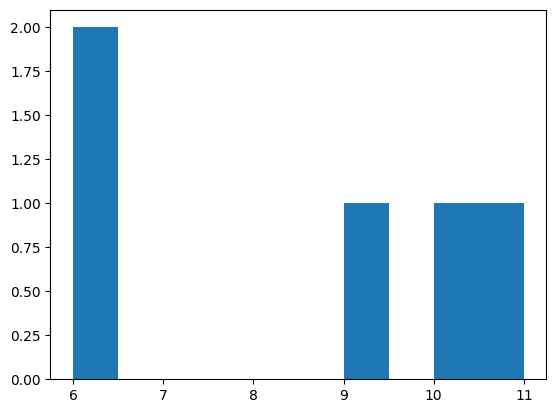

In [6]:
plt.hist(total_wins)
print(f'winrate: {int(100*sum(total_wins)/len(total_wins)/11)}%')

### Visualize a model

In [7]:
model = models[0]
# use %magic to make plots pop up in a separate window
%matplotlib qt
tournament = Tournament(HexGame, NeuralNetPlayer(model=model), RandomPlayer(), boardSize=boardSize, plot=True)
tournament.run(1)

### Save model

In [ ]:
# model.save('model.h5')